# Final submission(s)

In this notebook some final work is done to improve the kaggle submission score. Rather than looking for innovative ways, some interesting ideas from Kaggle are used or more basic ideas from myself that might improve score.

## Load data

In [1]:
import numpy as np 
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns

In [2]:
# https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635
def customer_hex_id_to_int(series):
    return series.str[-16:].apply(hex_id_to_int)

def hex_id_to_int(str):
    return int(str[-16:], 16)

def article_id_str_to_int(series):
    return series.astype('int32')

def article_id_int_to_str(series):
    return '0' + series.astype('str')

class Categorize(BaseEstimator, TransformerMixin):
    def __init__(self, min_examples=0):
        self.min_examples = min_examples
        self.categories = []
        
    def fit(self, X):
        for i in range(X.shape[1]):
            vc = X.iloc[:, i].value_counts()
            self.categories.append(vc[vc > self.min_examples].index.tolist())
        return self

    def transform(self, X):
        data = {X.columns[i]: pd.Categorical(X.iloc[:, i], categories=self.categories[i]).codes for i in range(X.shape[1])}
        return pd.DataFrame(data=data)


In [3]:
# load preprocessed data with parquet
transactions = pd.read_parquet('transactions_train.parquet')
customers = pd.read_parquet('customers.parquet')
articles = pd.read_parquet('articles.parquet')

In [4]:
test_week = transactions.week.max() + 1
transactions = transactions[transactions.week > transactions.week.max() - 10]

## Candidates and samples from previous notebooks

In [5]:
# Get all weeks a customer purchased articles in
purch_weeks = transactions.groupby('customer_id')['week'].unique()

In [6]:
# create a mapping from every week a purchase was made to the next week a purchase was made
# the last purchase week is mapped to the test week
purch_weeks_next = {}

for c_id, weeks in purch_weeks.items():
    purch_weeks_next[c_id] = {}
    for i in range(weeks.shape[0]-1):
        purch_weeks_next[c_id][weeks[i]] = weeks[i+1]
    purch_weeks_next[c_id][weeks[-1]] = test_week

In [7]:
# the repurchase samples will be based on the original transactions
repurchase_samples = transactions.copy()

In [8]:
# use week mappings to set weeks in repurchase samples
weeks = []
for i, (c_id, week) in enumerate(zip(transactions['customer_id'], transactions['week'])):
    weeks.append(purch_weeks_next[c_id][week])
repurchase_samples.week=weeks

In [9]:
# get the mean price of each article on a weekly basis
mean_price = transactions \
    .groupby(['week', 'article_id'])['price'].mean()

In [10]:
# for each week get the top 12 items sold, assign them a rank
sales = transactions \
    .groupby('week')['article_id'].value_counts() \
    .groupby('week').rank(method='dense', ascending=False) \
    .groupby('week').head(12).rename('bestseller_rank').astype('int8')

In [11]:
# create dataframe stating for each item the bestseller rank of the item in the previous week
bestsellers_previous_week = pd.merge(sales, mean_price, on=['week', 'article_id']).reset_index()
bestsellers_previous_week.week += 1

In [12]:
# get unique transaction for every user and week it was active in
unique_transactions = transactions \
    .groupby(['week', 'customer_id']) \
    .head(1) \
    .drop(columns=['article_id', 'price']) \
    .copy()

In [13]:
# create samples of of items that were sold the most in the week before the sample
bestseller_samples = pd.merge(
    unique_transactions,
    bestsellers_previous_week,
    on='week',
)

In [14]:
# create one transactions for each user in the test week
test_set_transactions = unique_transactions.drop_duplicates('customer_id').reset_index(drop=True)
test_set_transactions.week = test_week

In [15]:
# generate bestseller candidates
bestseller_candidates = pd.merge(
    test_set_transactions,
    bestsellers_previous_week,
    on='week'
)

In [16]:
# concatenate all bestseller samples, drop ranking column
bestseller_samples = pd.concat([bestseller_samples, bestseller_candidates])
bestseller_samples.drop(columns='bestseller_rank', inplace=True)
bestseller_samples["is_bestseller"] = 1

## Item pairs
An interesting recommendations that most sites nowadays adopt is "frequently bought together". It might be interesting to look at the articles that are bought together most frequently. This has already been discussed on Kaggle with many notebooks, I will be using the following notebook: https://www.kaggle.com/code/titericz/article-id-pairs-in-3s-using-cudf/notebook

In [17]:
def create_pairs(ratio = True):
    
    # get all articles bought by a user and put it in pair column
    dt = transactions.groupby(['customer_id','t_dat'])['article_id'].agg(list).rename('pair').reset_index()
    df = transactions[['customer_id', 't_dat', 'article_id']].merge(dt, on=['customer_id', 't_dat'], how='left')
    
    # count the amount of pairs each article has
    article_count = df.groupby('article_id').size().rename('article_count')

    
    # explode pair column, creating a row for every entry in list
    df = df[['article_id', 'pair']].explode(column='pair')
    
    # discard articles paired with itself
    df = df.loc[df['article_id'] != df['pair']].reset_index(drop=True)
    
    # count the amount of times a pair occurs and save this count
    df = df.groupby(['article_id', 'pair']).size().rename('count').reset_index()
    
    # sort by ratio
    if ratio:
        df = pd.merge(df, article_count, on="article_id")
        df['ratio'] = df['count'] / df['article_count']
        df = df.sort_values(['article_id' ,'ratio'], ascending=False).reset_index(drop=True)
    else:
        df = df.sort_values(['article_id' ,'count'], ascending=False).reset_index(drop=True)


    
    # Filter on item pairs with highest count (so only one pair per article_id)
    df['pair_rank'] = df.groupby('article_id')['pair'].cumcount()
    df = df.loc[df['pair_rank']<12].reset_index(drop=True) + 1
    
    return df

In [18]:
df = create_pairs(False)

<AxesSubplot:xlabel='article_id', ylabel='count'>

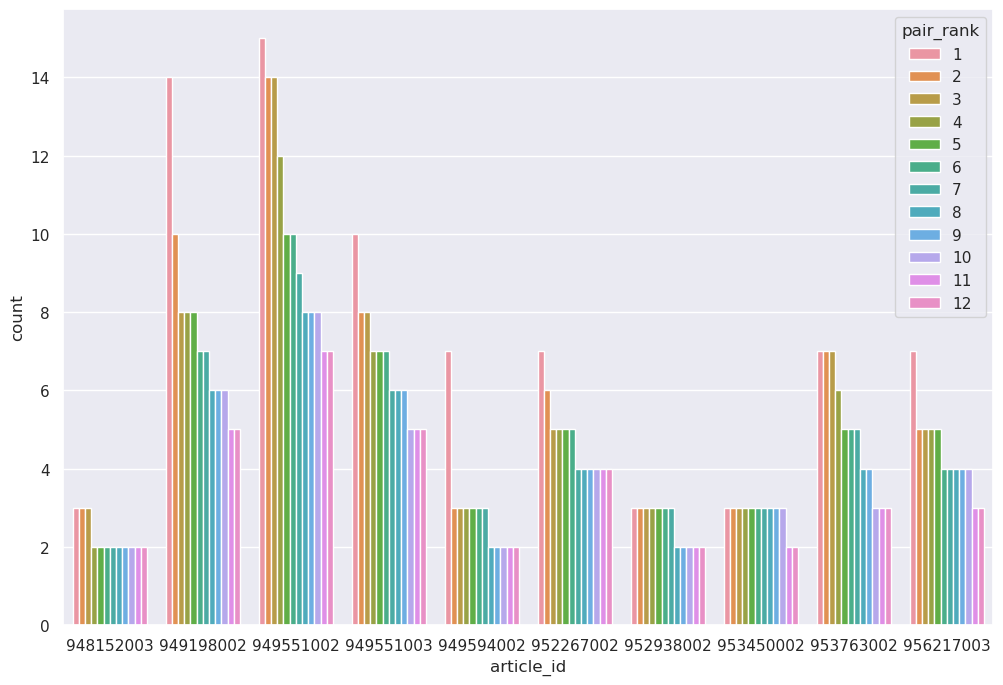

In [19]:
sns.set(rc={"figure.figsize": (12, 8)})
sns.barplot(data=df.head(120), x="article_id", y="count", hue="pair_rank")

In [20]:
cus2art = transactions[["customer_id", "article_id"]]

In [21]:
cust2pair = pd.merge(cus2art, df, on="article_id")[["customer_id", "pair", "pair_rank"]].rename(columns={"pair": "article_id"})

In [22]:
sample_pairs = pd.merge(unique_transactions, cust2pair, on="customer_id")

In [23]:
# create unique transactions for each pair candidate
unique_transactions_pairs = pd.merge(test_set_transactions, cust2pair, on="customer_id")

In [24]:
# mean price of every item
# compute mean price and add info to candidates
overall_mean_price = transactions.groupby('article_id')['price'].mean()

In [25]:
pairs_candidates = pd.merge(unique_transactions_pairs, overall_mean_price, on="article_id")
pairs_candidates["is_pair"] = 1

In [26]:
sample_pairs = pd.merge(sample_pairs, overall_mean_price, on="article_id")
sample_pairs["is_pair"] = 1

## Combine with baseline

In [27]:
transactions['purchased'] = 1

In [28]:
# combine transactions, negative samples and candidates
data = pd.concat([transactions, repurchase_samples, sample_pairs, bestseller_samples, pairs_candidates])
data.is_pair.fillna(0, inplace=True)
data.is_bestseller.fillna(0, inplace=True)
data.purchased.fillna(0, inplace=True)
data = pd.merge(
    data,
    bestsellers_previous_week[['week', 'article_id', 'bestseller_rank']],
    on=['week', 'article_id'],
    how='left'
)
data.fillna(999, inplace=True)
data = data[data.week != data.week.min()]

In [29]:
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

In [30]:
# add article and customer info
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')

In [31]:
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [32]:
# train test split
train = data[data.week != test_week]
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()

In [33]:
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values

In [34]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank', 'pair_rank', "is_pair", "is_bestseller"]

In [35]:
train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

In [36]:
from lightgbm.sklearn import LGBMRanker

In [37]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=2000,
    importance_type='gain',
    verbose=10,
    eval_at=12
)

In [38]:
ranker = ranker.fit(
    train_X,
    train_y,
    eval_set=[(train_X, train_y)],
    group=train_baskets,
    eval_group=[train_baskets]
)

/home/mateoking2000/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:621: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.108172
[LightGBM] [Debug] init for col-wise cost 0.000076 seconds, init for row-wise cost 0.746085 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.276368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1156
[LightGBM] [Info] Number of data points in the train set: 21488509, number of used features: 21
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[1]	training's ndcg@12: 0.921353
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[2]	training's ndcg@12: 0.915058
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[3]	training's ndcg@12: 0.912312
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[4]	training's ndcg@12: 0.911581
[LightGBM] [Debug] Trai

[77]	training's ndcg@12: 0.913872
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[78]	training's ndcg@12: 0.913876
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[79]	training's ndcg@12: 0.913909
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[80]	training's ndcg@12: 0.913931
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[81]	training's ndcg@12: 0.913926
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[82]	training's ndcg@12: 0.913962
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[83]	training's ndcg@12: 0.913976
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[84]	training's ndcg@12: 0.913982
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[85]	training's ndcg@12: 0.913977
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[86]	training's ndcg@12: 0.914013
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12


[159]	training's ndcg@12: 0.9147
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[160]	training's ndcg@12: 0.914694
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[161]	training's ndcg@12: 0.914726
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[162]	training's ndcg@12: 0.914737
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[163]	training's ndcg@12: 0.914746
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[164]	training's ndcg@12: 0.91475
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[165]	training's ndcg@12: 0.914796
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[166]	training's ndcg@12: 0.914831
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[167]	training's ndcg@12: 0.914856
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[168]	training's ndcg@12: 0.914882
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[241]	training's ndcg@12: 0.915899
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[242]	training's ndcg@12: 0.915932
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[243]	training's ndcg@12: 0.915928
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[244]	training's ndcg@12: 0.915915
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[245]	training's ndcg@12: 0.915929
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[246]	training's ndcg@12: 0.915989
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[247]	training's ndcg@12: 0.916038
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[248]	training's ndcg@12: 0.916026
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[249]	training's ndcg@12: 0.916035
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[250]	training's ndcg@12:

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[323]	training's ndcg@12: 0.917045
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[324]	training's ndcg@12: 0.917035
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[325]	training's ndcg@12: 0.917068
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[326]	training's ndcg@12: 0.917053
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[327]	training's ndcg@12: 0.917087
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[328]	training's ndcg@12: 0.917096
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[329]	training's ndcg@12: 0.917125
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[330]	training's ndcg@12: 0.917109
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[331]	training's ndcg@12: 0.917112
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[332]	training's ndcg@12: 0

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[405]	training's ndcg@12: 0.917917
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[406]	training's ndcg@12: 0.917915
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[407]	training's ndcg@12: 0.917928
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[408]	training's ndcg@12: 0.91792
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[409]	training's ndcg@12: 0.917957
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[410]	training's ndcg@12: 0.917982
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[411]	training's ndcg@12: 0.917983
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[412]	training's ndcg@12: 0.917986
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[413]	training's ndcg@12: 0.917974
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[414]	training's ndcg@12: 0

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[487]	training's ndcg@12: 0.918825
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[488]	training's ndcg@12: 0.918831
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[489]	training's ndcg@12: 0.918861
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[490]	training's ndcg@12: 0.918855
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[491]	training's ndcg@12: 0.918851
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[492]	training's ndcg@12: 0.918847
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[493]	training's ndcg@12: 0.91884
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[494]	training's ndcg@12: 0.91886
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[495]	training's ndcg@12: 0.918887
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[496]	training's ndcg@12: 0.

[568]	training's ndcg@12: 0.919504
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[569]	training's ndcg@12: 0.919501
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[570]	training's ndcg@12: 0.919498
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[571]	training's ndcg@12: 0.919512
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[572]	training's ndcg@12: 0.919514
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[573]	training's ndcg@12: 0.919517
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[574]	training's ndcg@12: 0.919513
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[575]	training's ndcg@12: 0.919542
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[576]	training's ndcg@12: 0.91953
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[577]	training's ndcg@12: 0.91953
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[650]	training's ndcg@12: 0.919892
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[651]	training's ndcg@12: 0.919911
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[652]	training's ndcg@12: 0.91991
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[653]	training's ndcg@12: 0.91991
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[654]	training's ndcg@12: 0.919908
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[655]	training's ndcg@12: 0.919927
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[656]	training's ndcg@12: 0.919937
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[657]	training's ndcg@12: 0.919935
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[658]	training's ndcg@12: 0.919956
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[659]	training's ndcg@12: 0.

[731]	training's ndcg@12: 0.920334
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[732]	training's ndcg@12: 0.920334
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[733]	training's ndcg@12: 0.920345
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[734]	training's ndcg@12: 0.920345
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[735]	training's ndcg@12: 0.920365
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[736]	training's ndcg@12: 0.920357
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[737]	training's ndcg@12: 0.920357
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[738]	training's ndcg@12: 0.920392
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[739]	training's ndcg@12: 0.920405
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[740]	training's ndcg@12: 0.920441
[LightGBM] [Debug] Trained a tree with leaves = 31 and dep

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[813]	training's ndcg@12: 0.92074
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[814]	training's ndcg@12: 0.920743
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[815]	training's ndcg@12: 0.920739
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[816]	training's ndcg@12: 0.920758
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[817]	training's ndcg@12: 0.920762
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[818]	training's ndcg@12: 0.920767
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[819]	training's ndcg@12: 0.920759
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[820]	training's ndcg@12: 0.920758
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[821]	training's ndcg@12: 0.92077
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[822]	training's ndcg@12: 0.9

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[895]	training's ndcg@12: 0.921259
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[896]	training's ndcg@12: 0.921258
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[897]	training's ndcg@12: 0.921255
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[898]	training's ndcg@12: 0.921255
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[899]	training's ndcg@12: 0.921272
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[900]	training's ndcg@12: 0.921288
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[901]	training's ndcg@12: 0.921289
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[902]	training's ndcg@12: 0.921294
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[903]	training's ndcg@12: 0.921305
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[904]	training's ndcg@12:

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[977]	training's ndcg@12: 0.921647
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[978]	training's ndcg@12: 0.921647
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[979]	training's ndcg@12: 0.921652
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[980]	training's ndcg@12: 0.921666
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[981]	training's ndcg@12: 0.921662
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[982]	training's ndcg@12: 0.921665
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[983]	training's ndcg@12: 0.921669
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[984]	training's ndcg@12: 0.921677
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[985]	training's ndcg@12: 0.921673
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[986]	training's ndcg@12: 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1058]	training's ndcg@12: 0.922094
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1059]	training's ndcg@12: 0.922098
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1060]	training's ndcg@12: 0.922096
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[1061]	training's ndcg@12: 0.922101
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[1062]	training's ndcg@12: 0.922096
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[1063]	training's ndcg@12: 0.922096
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[1064]	training's ndcg@12: 0.922095
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1065]	training's ndcg@12: 0.922096
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1066]	training's ndcg@12: 0.922109
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[1067]	training's 

[1138]	training's ndcg@12: 0.922331
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[1139]	training's ndcg@12: 0.922329
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1140]	training's ndcg@12: 0.922339
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[1141]	training's ndcg@12: 0.922336
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1142]	training's ndcg@12: 0.922335
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[1143]	training's ndcg@12: 0.922349
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1144]	training's ndcg@12: 0.922359
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1145]	training's ndcg@12: 0.92236
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1146]	training's ndcg@12: 0.922364
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[1147]	training's ndcg@12: 0.922374
[LightGBM] [Debug] Trained a tree with leaves =

[1219]	training's ndcg@12: 0.922631
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1220]	training's ndcg@12: 0.922642
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[1221]	training's ndcg@12: 0.922643
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1222]	training's ndcg@12: 0.92265
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1223]	training's ndcg@12: 0.922654
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1224]	training's ndcg@12: 0.922653
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1225]	training's ndcg@12: 0.922656
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[1226]	training's ndcg@12: 0.922662
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1227]	training's ndcg@12: 0.922662
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1228]	training's ndcg@12: 0.922663
[LightGBM] [Debug] Trained a tree with leaves = 3

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1301]	training's ndcg@12: 0.922859
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1302]	training's ndcg@12: 0.92286
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[1303]	training's ndcg@12: 0.922859
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1304]	training's ndcg@12: 0.922862
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[1305]	training's ndcg@12: 0.922864
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1306]	training's ndcg@12: 0.922867
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1307]	training's ndcg@12: 0.922867
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1308]	training's ndcg@12: 0.92287
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1309]	training's ndcg@12: 0.922881
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[1310]	training's n

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1382]	training's ndcg@12: 0.923171
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[1383]	training's ndcg@12: 0.92317
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1384]	training's ndcg@12: 0.92317
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[1385]	training's ndcg@12: 0.923173
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1386]	training's ndcg@12: 0.923171
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1387]	training's ndcg@12: 0.923174
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[1388]	training's ndcg@12: 0.923187
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[1389]	training's ndcg@12: 0.92319
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1390]	training's ndcg@12: 0.92321
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[1391]	training's ndcg

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1463]	training's ndcg@12: 0.923443
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[1464]	training's ndcg@12: 0.923438
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[1465]	training's ndcg@12: 0.92344
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1466]	training's ndcg@12: 0.923438
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[1467]	training's ndcg@12: 0.923441
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1468]	training's ndcg@12: 0.923444
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1469]	training's ndcg@12: 0.923443
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1470]	training's ndcg@12: 0.923462
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[1471]	training's ndcg@12: 0.923463
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1472]	training's 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1544]	training's ndcg@12: 0.923623
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[1545]	training's ndcg@12: 0.92362
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1546]	training's ndcg@12: 0.923617
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1547]	training's ndcg@12: 0.92362
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1548]	training's ndcg@12: 0.923629
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1549]	training's ndcg@12: 0.92364
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1550]	training's ndcg@12: 0.923649
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1551]	training's ndcg@12: 0.923651
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1552]	training's ndcg@12: 0.923648
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[1553]	training's nd

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1625]	training's ndcg@12: 0.923873
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1626]	training's ndcg@12: 0.923883
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1627]	training's ndcg@12: 0.923888
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[1628]	training's ndcg@12: 0.923889
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1629]	training's ndcg@12: 0.923884
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1630]	training's ndcg@12: 0.923898
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1631]	training's ndcg@12: 0.923904
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[1632]	training's ndcg@12: 0.923905
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1633]	training's ndcg@12: 0.923905
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1634]	training's

[1705]	training's ndcg@12: 0.924254
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1706]	training's ndcg@12: 0.92425
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1707]	training's ndcg@12: 0.92425
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1708]	training's ndcg@12: 0.924251
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1709]	training's ndcg@12: 0.924253
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1710]	training's ndcg@12: 0.924257
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[1711]	training's ndcg@12: 0.924254
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1712]	training's ndcg@12: 0.924271
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1713]	training's ndcg@12: 0.924271
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1714]	training's ndcg@12: 0.924282
[LightGBM] [Debug] Trained a tree with leaves = 3

[1786]	training's ndcg@12: 0.924528
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1787]	training's ndcg@12: 0.924546
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1788]	training's ndcg@12: 0.924549
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1789]	training's ndcg@12: 0.924546
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[1790]	training's ndcg@12: 0.924541
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[1791]	training's ndcg@12: 0.924541
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1792]	training's ndcg@12: 0.924547
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1793]	training's ndcg@12: 0.924548
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1794]	training's ndcg@12: 0.924549
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1795]	training's ndcg@12: 0.924551
[LightGBM] [Debug] Trained a tree with leaves = 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1868]	training's ndcg@12: 0.92479
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1869]	training's ndcg@12: 0.9248
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[1870]	training's ndcg@12: 0.924798
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1871]	training's ndcg@12: 0.924799
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[1872]	training's ndcg@12: 0.92481
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1873]	training's ndcg@12: 0.924807
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1874]	training's ndcg@12: 0.924808
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[1875]	training's ndcg@12: 0.924807
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1876]	training's ndcg@12: 0.924819
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[1877]	training's ndc

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[1949]	training's ndcg@12: 0.925038
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[1950]	training's ndcg@12: 0.925044
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1951]	training's ndcg@12: 0.925052
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1952]	training's ndcg@12: 0.925056
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1953]	training's ndcg@12: 0.925059
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[1954]	training's ndcg@12: 0.925061
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[1955]	training's ndcg@12: 0.925061
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[1956]	training's ndcg@12: 0.925058
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[1957]	training's ndcg@12: 0.92506
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[1958]	training's

In [39]:
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

is_bestseller 0.4475834480874843
pair_rank 0.41951796731963653
is_pair 0.04908158666249119
article_id 0.026075708037377465
product_type_no 0.016273826145781472
department_no 0.011487166688874848
garment_group_no 0.007325983529334026
colour_group_code 0.004845243365275705
graphical_appearance_no 0.004448725204337573
section_no 0.00355536021576324
perceived_colour_master_id 0.0030910977170975056
perceived_colour_value_id 0.002665792967901877
index_group_no 0.001121126179750138
index_code 0.0009824190278909528
bestseller_rank 0.0008090392670228544
age 0.0004635953891258687
postal_code 0.0004617912388253218
club_member_status 0.00014268257463583126
fashion_news_frequency 5.028400268301892e-05
FN 9.12243345009421e-06
Active 8.033945260168485e-06


In [40]:
# create predictions
test['preds'] = ranker.predict(test_X)

# order predicted articles per user
user_predicted_articles = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

# get bestsellers from last week before test week
bestsellers_last_week = \
    bestsellers_previous_week[bestsellers_previous_week.week == bestsellers_previous_week.week.max()]['article_id'].tolist()

In [41]:
sub = pd.read_csv('sample_submission.csv')

In [42]:
# reform predictions to correct format for submission
preds = []
for c_id in customer_hex_id_to_int(sub.customer_id):
    pred = user_predicted_articles.get(c_id, [])
    pred = pred + bestsellers_last_week
    preds.append(pred[:12])

preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = preds

In [43]:
# baseline submission
sub_name = 'article_pairs_ratio_submission'
sub.to_csv(f'{sub_name}.csv.gz', index=False)

Final best Kaggle public score: 0.02133